Import libraries

In [12]:
import os
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import plotly.graph_objs as go
from IPython.display import Image

**TRAINING**

**Load the Training Results and analyze them**

In [13]:
#@title
# load the selected Holonyms and Meronyms 
with open('../class_config.json') as json_file: 
  HOL_MER_DICT = json.load(json_file)
# load the training results
with open('../Results/train.json') as json_file: 
  train_dict = json.load(json_file)

num_parts_avg_f1scorec_dict = {}

# create a dict with format : num_parts -> [(holonym, score), (...), ...]
num_parts_holonym_score = {}
num_parts_score = {}
num_parts_holonym = {}

for i, holonym in enumerate(train_dict.keys()):
  m_dict = train_dict[holonym] # holonym class dict
  m_parts = m_dict['parts']    # holonym parts
  if len(m_parts) not in num_parts_holonym_score:
    num_parts_holonym_score[len(m_parts)] = []
    num_parts_score[len(m_parts)] = []
    num_parts_holonym[len(m_parts)] = []
 
  m_f1scorec = m_dict['f1score_c']
  m_f1scorec = [round(acc,2) for acc in m_f1scorec]
  
  m_min_f1scorec = np.min(m_f1scorec)
  m_max_f1scorec = np.max(m_f1scorec)
  m_avg_f1scorec = round(np.mean(m_f1scorec),2)

  num_parts_holonym_score[len(m_parts)].append((holonym, m_avg_f1scorec))
  num_parts_score[len(m_parts)].append(m_avg_f1scorec)
  num_parts_holonym[len(m_parts)].append(holonym)

  if len(m_parts) not in num_parts_avg_f1scorec_dict:
    num_parts_avg_f1scorec_dict[len(m_parts)] = []
  num_parts_avg_f1scorec_dict[len(m_parts)].append(m_avg_f1scorec)

num_parts_score = dict(sorted(num_parts_score.items()))
num_parts_holonym_score = dict(sorted(num_parts_holonym_score.items()))
num_parts_holonym = dict(sorted(num_parts_holonym.items()))

# split the holonym into animals, tools and vehicles categories
holonyms = list(HOL_MER_DICT.keys())
animals = holonyms[:32]
tools = holonyms[32:(32+13)]
vehicles = holonyms[(32+13):]

**Plot the Calibrated F1-score behavior**

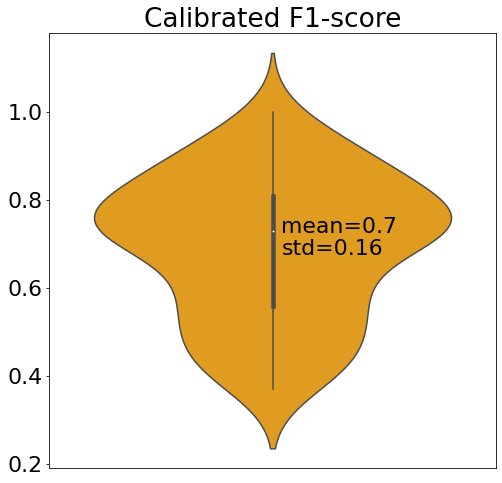

In [14]:
#@title
plt.rcParams.update({'font.size': 22})

f1_scores = list(num_parts_score.values())
f1_scores = list(np.concatenate(f1_scores).flat)
mean_f1 = round(np.mean(f1_scores),1) # 0.69 -> 0.7
std_f1 = round(np.std(f1_scores),2)

fig = plt.figure(figsize=(8,8))
ax = sns.violinplot(data=[f1_scores], color='orange')
ax.text(0+0.02, np.mean(f1_scores)+0.03, "mean=" + str(mean_f1))
ax.text(0+0.02, np.mean(f1_scores)-0.02, "std=" + str(std_f1))
plt.xticks([], )
plt.title('Calibrated F1-score')
plt.show()

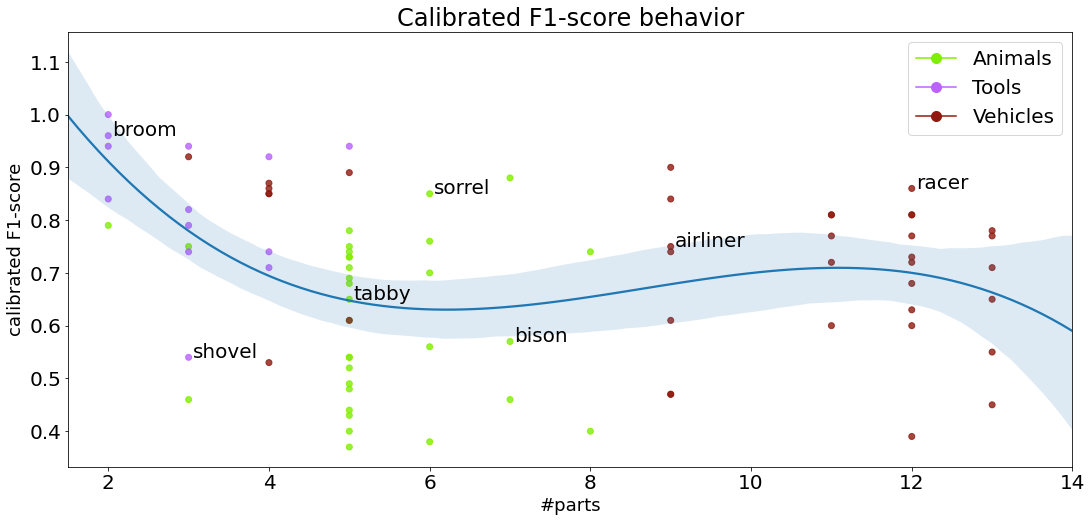

In [15]:
#@title
plt.rcParams.update({'font.size': 20})

# num_parts -> score
d = num_parts_score
x = list(np.hstack([[n_parts]*len(scores) for (n_parts,scores) in d.items()]))
y = list(np.hstack(list(num_parts_score.values())))
names = list(np.hstack([n for n in list(num_parts_holonym.values())]))
num_names = [(i, n) for i, n in enumerate(names)]
keep_name_idx = [1, 11, 22, 43, 50, 53, 73] # indexes of holonym classes to be shown
colors = []
for name in names:
  if name in animals:
    colors.append("#80ee00")
  elif name in tools:
    colors.append("#BA61FF")
  elif name in vehicles:
    colors.append("#8f190e")

plt.figure(figsize=(18,8))
plt.xlim(min(x)-0.5, max(x)+1)
plt.xlabel("#parts", fontsize=18)
plt.ylabel("calibrated F1-score", fontsize=18)

g = sns.regplot(x=x, y=y, order=3, truncate=False, scatter_kws={'color':colors})

legend_elements = [Line2D([0], [0], marker='o', color="#80ee00", label='Animals',
                          markerfacecolor="#80ee00", markersize=10),
                   Line2D([0], [0], marker='o', color="#BA61FF", label='Tools',
                          markerfacecolor="#BA61FF", markersize=10),
                   Line2D([0], [0], marker='o', color="#8f190e", label='Vehicles',
                          markerfacecolor="#8f190e", markersize=10),]

plt.legend(handles=legend_elements, loc='upper right')

# annotations
names = ['' if i not in keep_name_idx else n for i, n in enumerate(names)]
texts = [plt.text(x[i]+0.05, y[i], name) for i, name in enumerate(names)]

plt.title('Calibrated F1-score behavior')
plt.show()

**EXPLANATIONS**

**Load the Explanations Results and analyze them**

In [16]:
#@title
# load the selected Holonyms and Meronyms 
with open('../class_config.json') as json_file: 
  HOL_MER_DICT = json.load(json_file)
# load the explanations results
with open('../Results/exp.json') as json_file: 
  exp_dict = json.load(json_file)

# create a dictionary with the format: key(class), value(list of "part:average of score drops among images")
# keep only the top 5 parts, i.e. the ones with bigger drop
exp_results_dict = {}
# key(part), value(list of drops)
part_drops_dict = {}
all_drops = []
max_drops = []

for i, holonym in enumerate(exp_dict.keys()):
  m_dict = exp_dict[holonym]  # holonym class dict
  m_parts = m_dict['parts']   # holonym parts
  m_img_names = m_dict.keys() # imagenet validation images for the holonym
  m_per_part_drops = []
  for j, img_name in enumerate(m_img_names):
    if j>=50:
      break
    img_dict = m_dict[img_name]
    img_per_part_acc_drop = img_dict['score_drop'] # list of score drops, one per each part
    m_per_part_drops.append(img_per_part_acc_drop)
  # take the average over the columns
  m_avg_drops = np.mean(m_per_part_drops, axis=0) # average drop per part
  m_max_drop = np.max(m_avg_drops)
  # create dict with format: part, average part drop
  m_parts_avg_drops_dict = {part:drop for part,drop in zip(m_parts,m_avg_drops)}
  # reorder parts according to decreasing drops
  m_parts_avg_drops_dict = {k: v for k, v in sorted(m_parts_avg_drops_dict.items(), key=lambda item: item[1], reverse=True)}
  # retrieve the parts with top drops
  m_top_parts_len = min(len(m_parts_avg_drops_dict), 5)
  m_top_parts = [part for part in m_parts_avg_drops_dict.keys()][:m_top_parts_len]
  for top_part in m_top_parts:
    if top_part not in part_drops_dict:
      part_drops_dict[top_part] = []
    part_drops_dict[top_part].append([round(m_avg_drops[i], 2) for i in range(len(m_parts)) if (m_parts[i] == top_part)][0])
  all_drops = all_drops + sorted(m_avg_drops, reverse=True)[:m_top_parts_len]
  max_drops.append(m_max_drop)

# key(holonym), value(number of times the Holonym is in the top 5)
part_drops_count_dict = {k:len(v) for k,v in part_drops_dict.items()}
# sort by the number of times the Holonym is in the top 5
sorted_freq_dict = {k: v for k, v in sorted(part_drops_count_dict.items(), key=lambda item: item[1], reverse=True)}
sorted_freq_dict_f = {k:v for k,v in sorted_freq_dict.items()}

# count the frequency of the meronyms 
meronym_freq_dict = {}
for meronym_list in HOL_MER_DICT.values():
    for meronym in meronym_list:
      if meronym not in meronym_freq_dict:
        meronym_freq_dict[meronym]=0
      meronym_freq_dict[meronym]+=1

# sort the meronyms frequencies
sorted_meronym_freq_dict = {}
for meronym in sorted_freq_dict_f.keys():
  sorted_meronym_freq_dict[meronym] = meronym_freq_dict[meronym]

s_tot_values = list(sorted_meronym_freq_dict.values())

**Plot Mean average drop and Mean maximum drop**

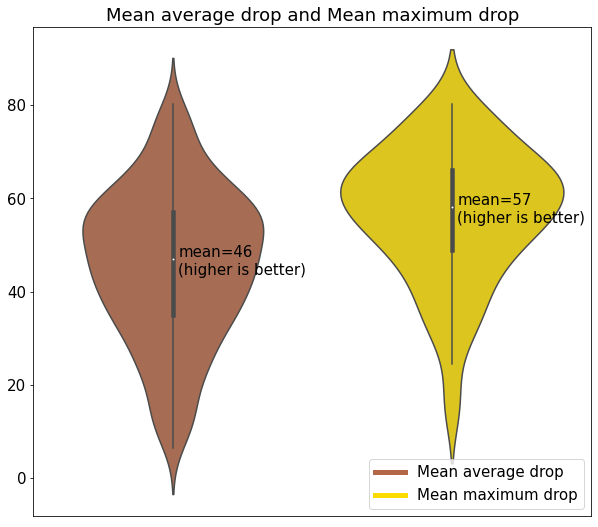

In [17]:
#@title
plt.rcParams.update({'font.size': 15})

x = ['Mean average drop','Mean maximum drop']

labels = ['Mean average drop','Mean maximum drop']
exp_mean_all = int(np.ceil(np.mean(all_drops)))
exp_mean_max = int(np.ceil(np.mean(max_drops)))
values = [exp_mean_all, exp_mean_max]

custom_lines = [Line2D([0], [0], color="#b46746", lw=5),
                Line2D([0], [0], color="#fcdc00", lw=5)]

fig = plt.figure(figsize=(10,9))
ax = sns.violinplot(data=[all_drops, max_drops], palette=["#b46746", "#fcdc00"])
ax.text(0+0.02, np.mean(all_drops)-2, "mean=" + str(exp_mean_all) + "\n(higher is better)")
ax.text(1+0.02, np.mean(max_drops)-2, "mean=" + str(exp_mean_max) + "\n(higher is better)")
plt.xticks([], )
plt.legend(custom_lines, x, loc='lower right')
plt.title('Mean average drop and Mean maximum drop')
plt.show()

**Plot the Meronyms Frequency**

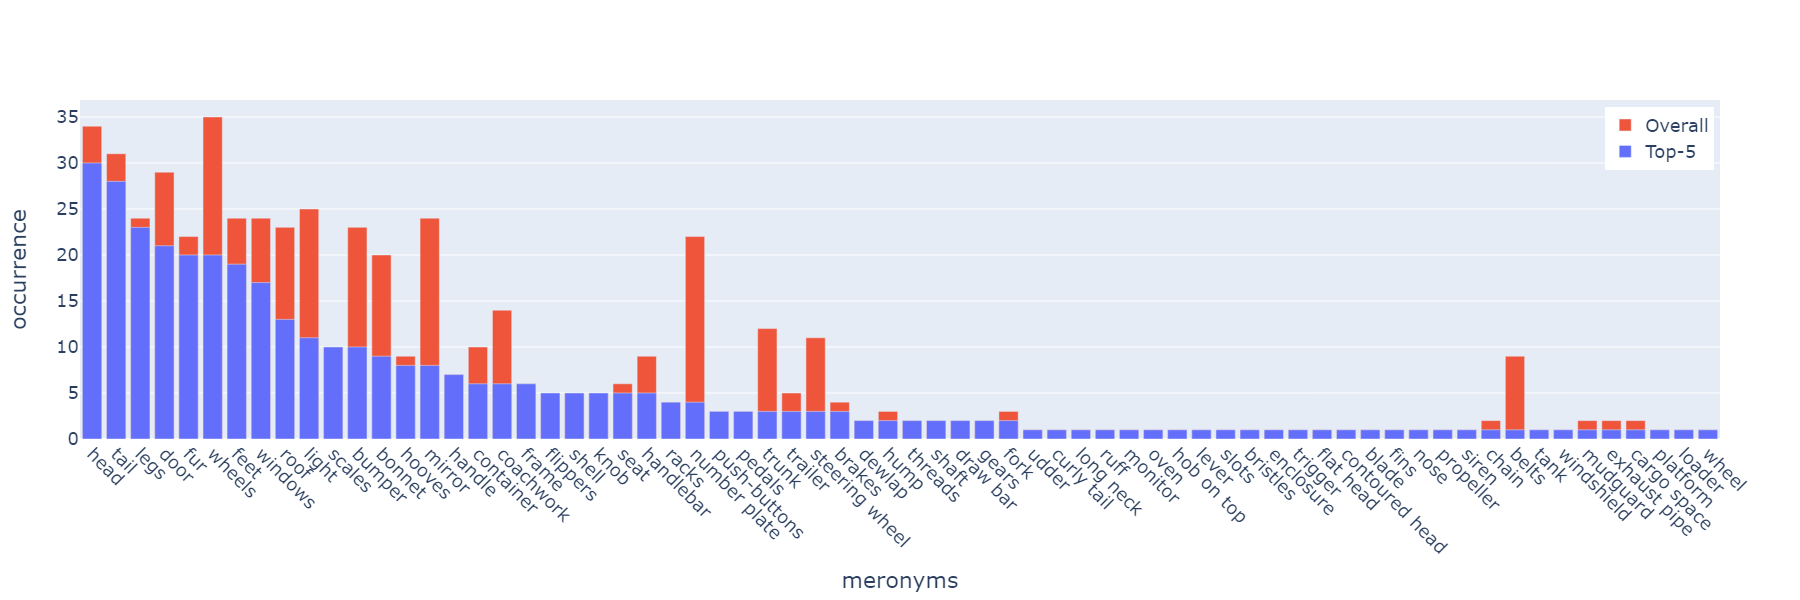

In [35]:
#@title
plt.rcParams.update({'font.size': 15})

sorted_freq_dict = {k: v for k, v in sorted(part_drops_count_dict.items(), key=lambda item: item[1], reverse=True)}
sorted_freq_dict_f = {k:v for k,v in sorted_freq_dict.items()}
s_labels = list(sorted_freq_dict_f.keys())
s_values = list(sorted_freq_dict_f.values())
ratio_values = [round((top_freq/all_freq) , 2) for top_freq, all_freq in zip(s_values, s_tot_values)]
s_labels_ratio = [(label + ' (' + str(ratio) +')') for label, ratio in zip(s_labels, ratio_values)]

fig = go.Figure([go.Bar(name="Overall", x=s_labels, y=s_tot_values, width=[0.8]*len(s_tot_values), marker_color="#EF553B"), go.Bar(name="Top-5", x=s_labels, y=s_values, marker_color="#636EFA")])
fig.update_layout(
    xaxis_title="meronyms",
    yaxis_title="occurrence",
    barmode='overlay',
    legend=dict(
    yanchor="top",
    y=0.98,
    xanchor="left",
    x=0.93,)
    )
fig.update_layout(font=dict(
        size=18,
    ))
fig.update_xaxes(tickangle=45)
img_bytes = fig.to_image(format="png", width=1800, height=600)
Image(img_bytes)

**EVALUATION**

**Load the Insertion/Deletion curves Results and analyze them**

In [19]:
#@title
# load the insertion/deletion curves results
with open('../Results/curves.json') as json_file: 
  curves_dict = json.load(json_file)

# data to record
m_avg_ins_auc_list = [] 
m_avg_del_auc_list = []
rand_m_avg_ins_list = []
rand_m_avg_del_auc_list = []
ins_ratio_list = []
del_ratio_list = []

num_parts_avg_ins_ratio_dict = {}
num_parts_avg_del_ratio_dict = {}

for i, holonym in enumerate(curves_dict.keys()):
  m_dict = curves_dict[holonym] # holonym class dict
  m_parts = m_dict['parts']     # holonym parts
  m_img_names = m_dict['del. curves'].keys() # imagenet validation images for the holonym
  m_per_part_ins_auc = []
  m_per_part_del_auc = []
  rand_m_per_part_ins_auc = []
  rand_m_per_part_del_auc = []
  for j, img_name in enumerate(m_img_names):
    if j>=50:
      break
    img_per_part_ins_auc = m_dict['ins. curves'][img_name][0]
    img_per_part_del_auc = m_dict['del. curves'][img_name][0]
    rand_img_per_part_ins_auc = np.mean(m_dict['random ins. curves'][img_name][0])
    rand_img_per_part_del_auc = np.mean(m_dict['random del. curves'][img_name][0])
    
    m_per_part_ins_auc.append(img_per_part_ins_auc)
    m_per_part_del_auc.append(img_per_part_del_auc)
    rand_m_per_part_ins_auc.append(rand_img_per_part_ins_auc)
    rand_m_per_part_del_auc.append(rand_img_per_part_del_auc)

  m_avg_ins_auc = np.mean(m_per_part_ins_auc, axis=0) # avg ins auc for holonym
  m_avg_del_auc = np.mean(m_per_part_del_auc, axis=0) # avg del auc for holonym
  rand_m_avg_ins_auc = np.mean(rand_m_per_part_ins_auc, axis=0) # avg ins auc for random hm (wrt holonym)
  rand_m_avg_del_auc = np.mean(rand_m_per_part_del_auc, axis=0) # avg del auc for random hm (wrt holonym)
  ins_ratio = m_avg_ins_auc / rand_m_avg_ins_auc
  del_ratio = m_avg_del_auc / rand_m_avg_del_auc

  m_avg_ins_auc_list.append(m_avg_ins_auc)
  m_avg_del_auc_list.append(m_avg_del_auc)
  rand_m_avg_ins_list.append(rand_m_avg_ins_auc)
  rand_m_avg_del_auc_list.append(rand_m_avg_del_auc)
  ins_ratio_list.append(ins_ratio)
  del_ratio_list.append(del_ratio)

  if len(m_parts) not in num_parts_avg_ins_ratio_dict:
    num_parts_avg_ins_ratio_dict[len(m_parts)] = []
    num_parts_avg_del_ratio_dict[len(m_parts)] = []
  num_parts_avg_ins_ratio_dict[len(m_parts)].append(ins_ratio)
  num_parts_avg_del_ratio_dict[len(m_parts)].append(del_ratio)

Average Insertion AUC and Average Deletion AUC

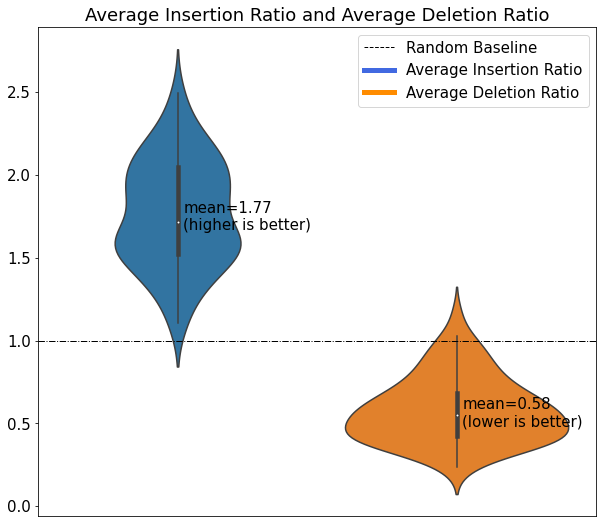

In [21]:
#@title
plt.rcParams.update({'font.size': 15})

custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle='--'),
                Line2D([0], [0], color="royalblue", lw=5),
                Line2D([0], [0], color="darkorange", lw=5)]

x = ['Random Baseline', 'Average Insertion Ratio','Average Deletion Ratio']
mean_ins_ratio = (round(np.mean(ins_ratio_list),2))
mean_del_ratio = (round(np.mean(del_ratio_list),2))

fig = plt.figure(figsize=(10,9))
ax = sns.violinplot(data=[ins_ratio_list, del_ratio_list])

ax.text(0+0.02, np.mean(ins_ratio_list)-0.1, "mean=" + str(mean_ins_ratio) + "\n(higher is better)")
ax.text(1+0.02, np.mean(del_ratio_list)-0.1, "mean=" + str(mean_del_ratio) + "\n(lower is better)")
ax.axhline(y=1.00, linewidth=1, color='k', linestyle='-.')
plt.xticks([], )
plt.legend(custom_lines, x, loc='upper right')
plt.title('Average Insertion Ratio and Average Deletion Ratio')
plt.show()